# **21AIE311 Reinforcement Learning**

# **Control of Robotic Manipulator using Q-Learning**

## **Team Members**

* **Kabilan N : CB.EN.U4AIE19033**
* **Sabarishwaran G : CB.EN.U4AIE19053**
* **Gokul Prazath Sri : CB.EN.U4AIE19062**

# **Importing Required Packages**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy.matlib

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings("ignore")

In [2]:
def s(t): return -4 * np.pi*(t/T)**3 + 6 * np.pi * (t/T)**2
def s_dot(t): return (-12 * np.pi * (t/T)**2 + 12 * np.pi * t/T)/T
def s_2dot(t): return (-24 * np.pi * t/T + 12 * np.pi)/(T**2)

In [3]:
r = np.pi;
def q_d(t): return np.array([r * np.cos(s(t)),r * np.sin(s(t))])
def q_d_dot(t): return np.array([-r * np.sin(s(t)) * s_dot(t), r * np.cos(s(t)) * s_dot(t)])
def q_2d_dot(t): return np.array([-r *  np.cos(s(t)) * s_dot(t)**2 - r * np.sin(s(t)) * s_2dot(t),-r * np.sin(s(t)) * s_dot(t)**2 + r * np.cos(s(t)) * s_2dot(t)])

# **Robot Model**

## **Physical Parameters**

In [4]:
T = 10
steps = 3000
time = np.linspace(0,T,steps)
step_size = T/steps

m1 = 2
m2 = 2
l1 = 1
l2 = 1
d1 = 0.5
d2 = 0.5
I1 = 1
I2 = 1
g0 = 9.81

## **Dynamic Coefficients**

In [5]:
a1 = I1 + I2 + m1 *  d1**2 + m2 * d2**2 + m2 * l1**2 # Total Moment of Inertia about origin
a2 = m2 * l2 * d2 # Torque about revolute joint 1
a3 = I2 + m2 * d2**2 # Moment of Inertia on Link2
a4 = g0 * (m1 * d1 + m2 * l1) # Total Gravitational torque
a5 = m2 * d2 * g0 # Gravitational torque for Link2

# B --> Inertial Matrix
# C --> Centripetal and Corriolis force Matrix
# g --> Gravitational Torque Matrix

def B(q): return np.array([[a1 + 2 * a2 * np.cos(q[1]),a2 * np.cos(q[1]) + a3],[a2 * np.cos(q[1]) + a3,a3]])
def c(q,q_dot): return np.array([-a2 * np.sin(q[1])*(q_dot[1]**2 + 2 * q_dot[0] * q_dot[1]), a2 * np.sin(q[1]) * q_dot[0]**2])
def g(q): return np.array([a4 * np.cos(q[0]) + a5 * np.cos(q[0] + q[1]),a5 * np.cos(q[0] + q[1])])

In [6]:
def fwd_dyn(q, q_dot, u):
    q = np.asarray(q)
    q_dot = np.asarray(q_dot)
    u = np.asarray(u)

    q = q.reshape(2)
    q_dot = q_dot.reshape(2)

    q_ddot = np.dot(np.linalg.inv(B(q)),u - c(q,q_dot) - g(q))    

    q += (q_dot * step_size + ( q_ddot * step_size**2) /2)
    q_dot += step_size * q_ddot

    return q,q_dot

In [7]:
robot_dim = len(q_d(0))
horizon = 10
state_dim = (2 + horizon) * robot_dim + 4 
output_dim = 1

In [8]:
agent_state = tf.placeholder(tf.float32,shape = [None,state_dim])
Q = tf.placeholder(tf.float32,shape = [None,output_dim])

In [9]:
def future_trajectory(time):
    q_ddot = []

    for i in range(horizon):
        q_ddot.append(q_2d_dot(time + (i + 1) * step_size))

    q_ddot = np.asarray(q_ddot)
    return q_ddot.ravel()

In [10]:
def weight_function(shape):
    w = tf.truncated_normal(shape)
    return tf.Variable(w)

In [11]:
def bias_function(shape):
    b = tf.zeros((shape))
    return tf.Variable(b)

In [12]:
dim_layer1 = 128

In [13]:
#Position Weights

w1 = weight_function([state_dim,dim_layer1])
w_out = weight_function([dim_layer1,output_dim])

print(np.shape(w1))
print(np.shape(w_out))

b1 = bias_function([dim_layer1])
b_out = bias_function([output_dim])

print(np.shape(b1))
print(np.shape(b_out))

(28, 128)
(128, 1)
(128,)
(1,)


In [14]:
def Q_network(x):

    hl1 = tf.add(tf.matmul(x,w1),b1)
    hl1 = tf.nn.tanh(hl1)

    ol = tf.add(tf.matmul(hl1,w_out),b_out)
    return ol

In [15]:
q_nn = Q_network(agent_state)
learning_rate = 0.1
loss = tf.reduce_mean(tf.square(Q - q_nn))
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [16]:
#opt = tf.train.AdamOptimizer()
train = opt.minimize(loss)

In [17]:
def reward(q,q_dot,time): return np.tanh(- np.linalg.norm(q_d(time)-q) - np.linalg.norm(q_d_dot(time)-q_dot))

# Discrete Actions
actions_position= [-3,-2,-1,0,1,2,3]
actions_velocity = [-0.6,-0.4,-0.2,0,0.2,0.4,0.6]

# TRAINING
initializzer = tf.global_variables_initializer()
sess = tf.Session()
initializzer.run(session = sess)

In [18]:
def gainsSaturation(Kp,Kd):

    if Kp < 10:
        Kp = 30
    if Kd < 2:
        Kd = 6
    if Kp > 200:
        Kp = 200
    if Kd > 40:
        Kd = 40
        
    return Kp,Kd

In [19]:
def run(state,time):
    
    # Kp & Kd are gain coefficents

    Kp = state[0][2 * robot_dim ]
    Kd = state[0][2 * robot_dim +1]

    a_position = state[0][2 * robot_dim + 2]
    a_velocity = state[0][2 * robot_dim + 3]
    
    Kp += a_position
    Kd += a_velocity

    q = state[0][0:robot_dim]
    q_dot = state[0][robot_dim:2 * robot_dim]

    # Initial Loss
    r = - reward(q,q_dot,time)

    t = time
    Kp,Kd = gainsSaturation(Kp, Kd)
    
    for idx in range(horizon):

        # Clip Time
        if ( t > T):
            t = t - T
            
        u = Kp * (q_d(t)-q) + Kd * (q_d_dot(t)-q_dot)
        r += reward(q,q_dot,t)
        q,q_dot = fwd_dyn(q,q_dot,u)
        t += step_size

    state[0][0:robot_dim] = q
    state[0][robot_dim:2 * robot_dim] = q_dot 
    state[0][2 * robot_dim] = Kp
    state[0][2 * robot_dim + 1] = Kd
    return r,state

In [20]:
runs = 50
Kp = 50
Kd = 10
epsilon = 0.9

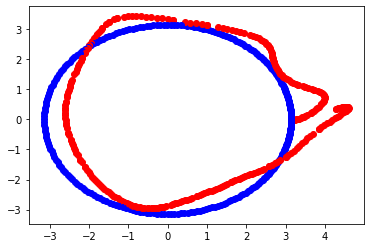

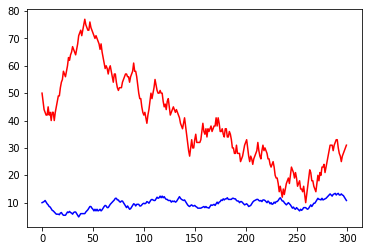

Episode : 1------Total Loss : nan------Epsilon : 0.63


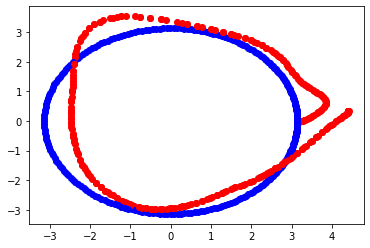

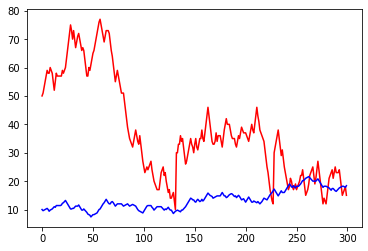

Episode : 2------Total Loss : nan------Epsilon : 0.63


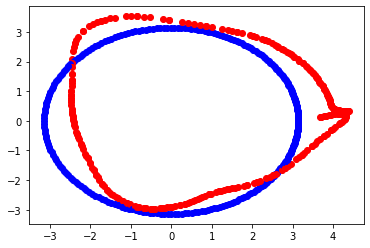

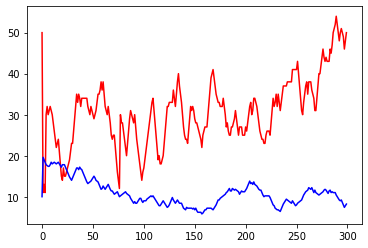

Episode : 3------Total Loss : nan------Epsilon : 0.63


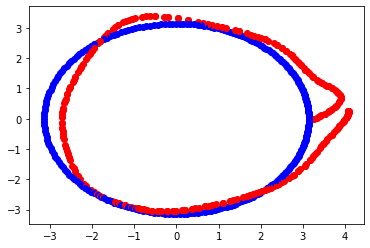

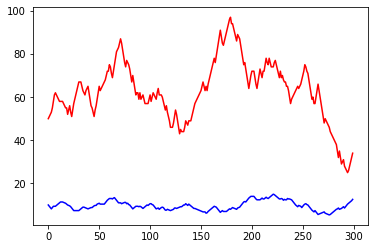

Episode : 4------Total Loss : nan------Epsilon : 0.44099999999999995


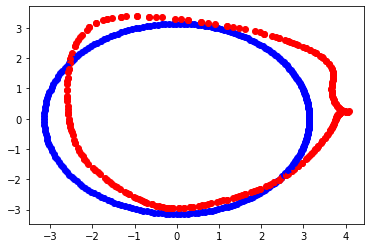

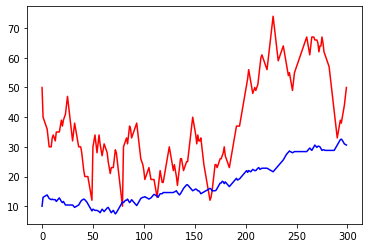

Episode : 5------Total Loss : nan------Epsilon : 0.44099999999999995


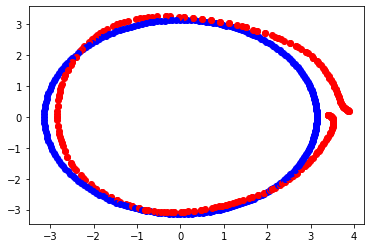

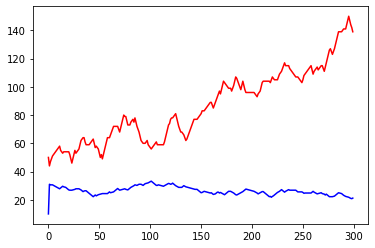

Episode : 6------Total Loss : nan------Epsilon : 0.44099999999999995


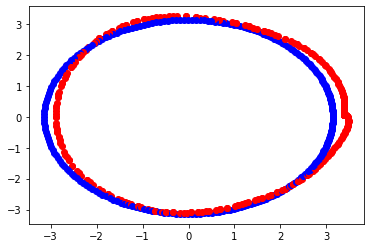

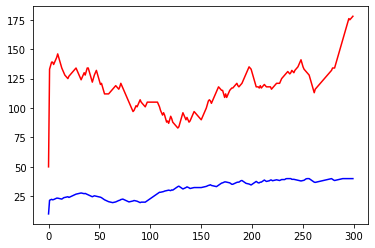

Episode : 7------Total Loss : nan------Epsilon : 0.3086999999999999


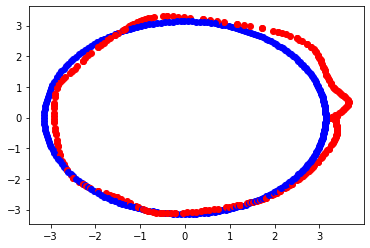

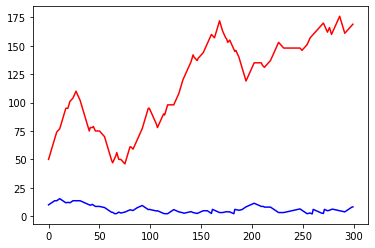

Episode : 8------Total Loss : nan------Epsilon : 0.3086999999999999


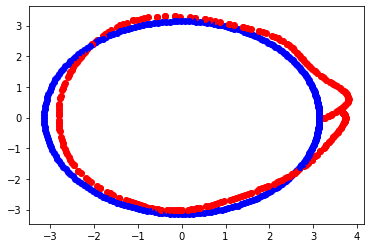

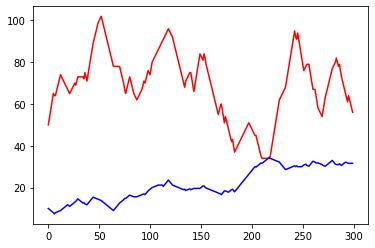

Episode : 9------Total Loss : nan------Epsilon : 0.3086999999999999


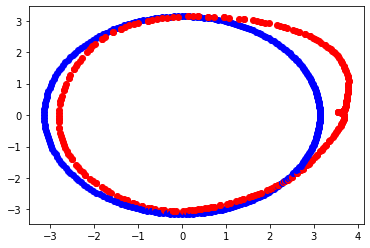

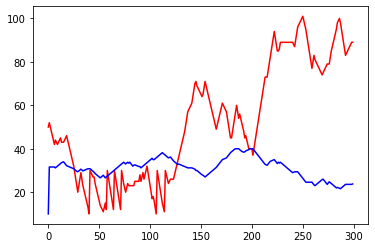

Episode : 10------Total Loss : nan------Epsilon : 0.21608999999999992


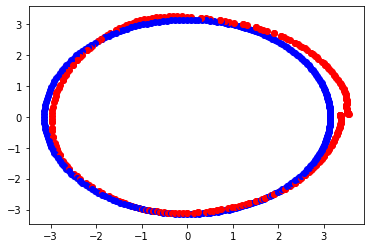

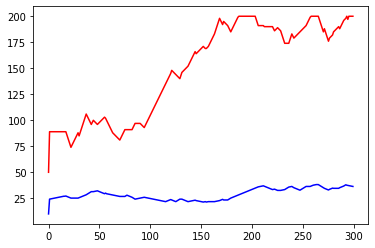

Episode : 11------Total Loss : nan------Epsilon : 0.21608999999999992


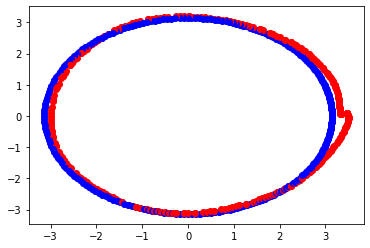

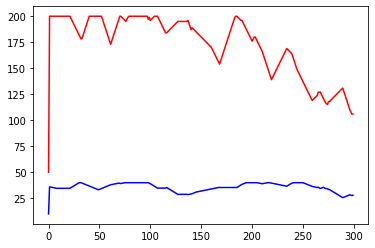

Episode : 12------Total Loss : nan------Epsilon : 0.21608999999999992


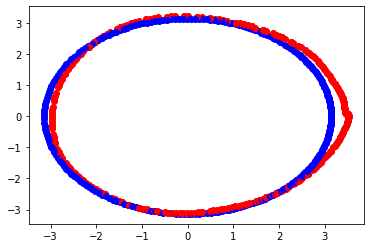

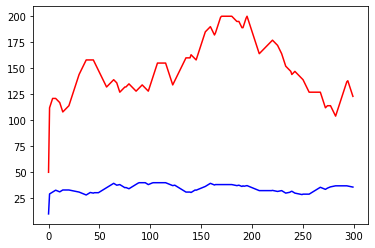

Episode : 13------Total Loss : nan------Epsilon : 0.15126299999999993


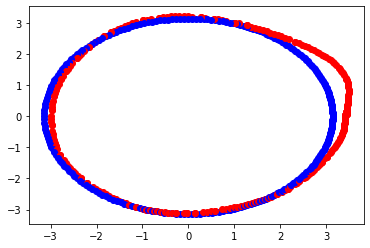

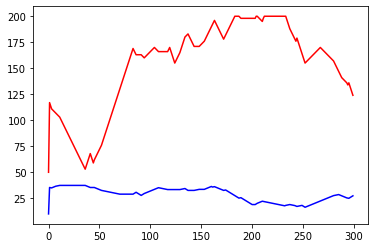

Episode : 14------Total Loss : nan------Epsilon : 0.15126299999999993


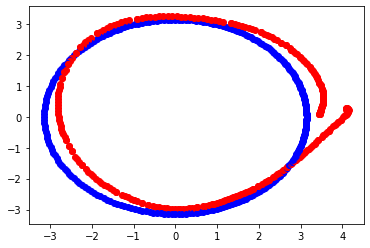

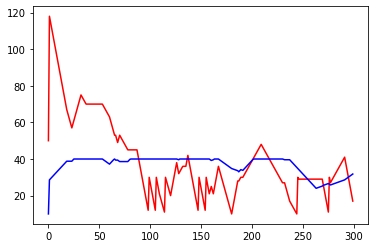

Episode : 15------Total Loss : nan------Epsilon : 0.15126299999999993


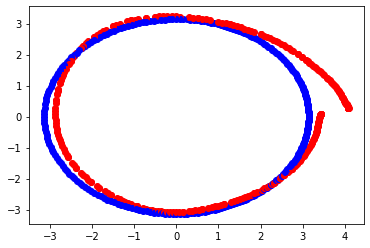

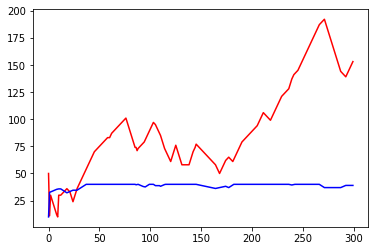

Episode : 16------Total Loss : nan------Epsilon : 0.10588409999999994


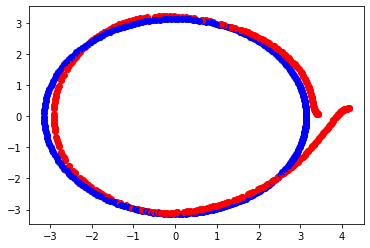

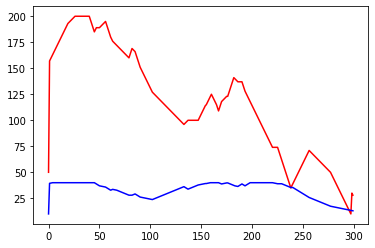

Episode : 17------Total Loss : nan------Epsilon : 0.10588409999999994


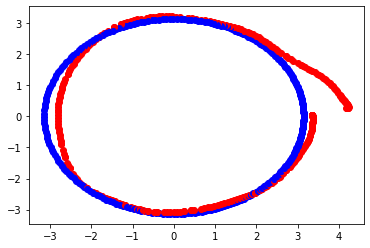

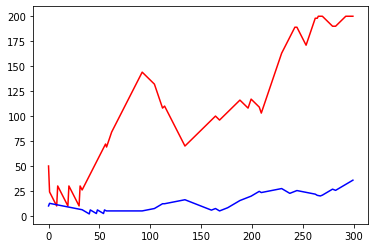

Episode : 18------Total Loss : nan------Epsilon : 0.10588409999999994


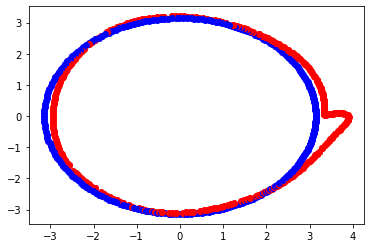

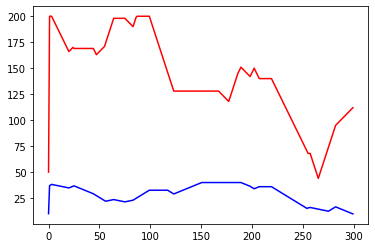

Episode : 19------Total Loss : nan------Epsilon : 0.07411886999999995


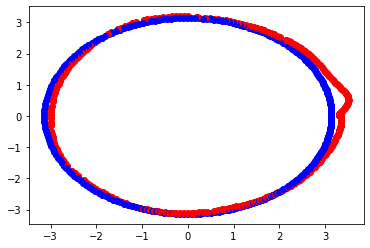

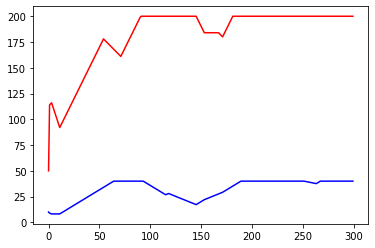

Episode : 20------Total Loss : nan------Epsilon : 0.07411886999999995


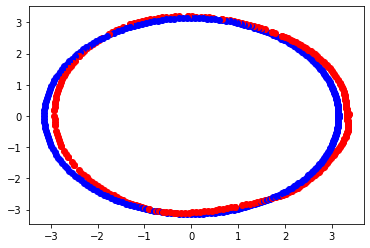

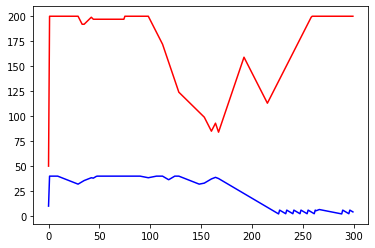

Episode : 21------Total Loss : nan------Epsilon : 0.07411886999999995


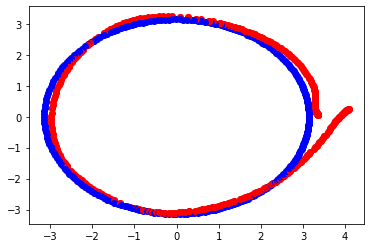

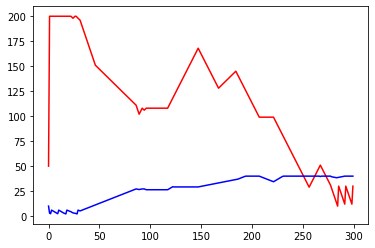

Episode : 22------Total Loss : nan------Epsilon : 0.05188320899999996


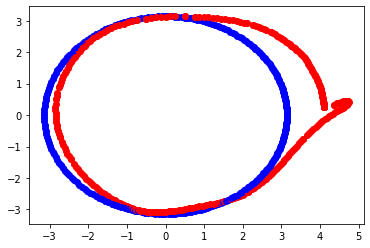

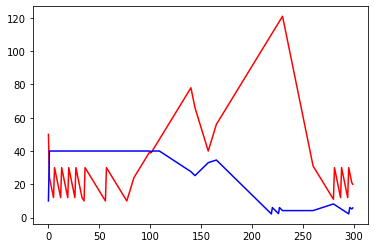

Episode : 23------Total Loss : nan------Epsilon : 0.05188320899999996


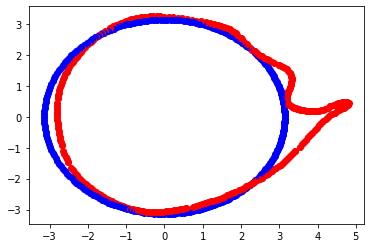

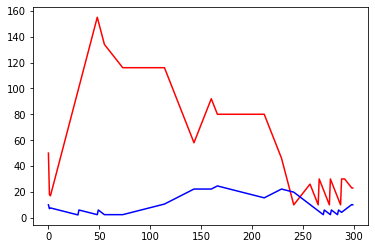

Episode : 24------Total Loss : nan------Epsilon : 0.05188320899999996


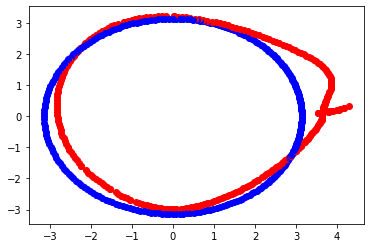

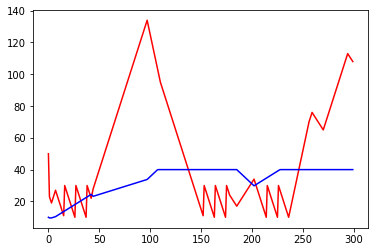

Episode : 25------Total Loss : nan------Epsilon : 0.03631824629999997


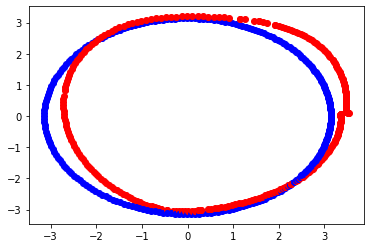

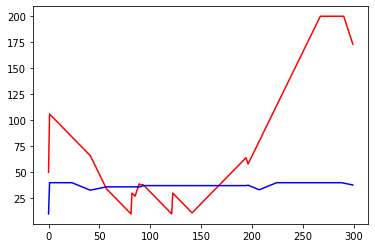

Episode : 26------Total Loss : nan------Epsilon : 0.03631824629999997


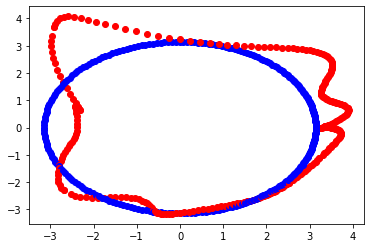

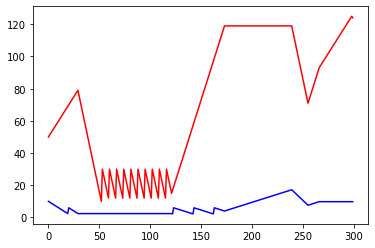

Episode : 27------Total Loss : nan------Epsilon : 0.03631824629999997


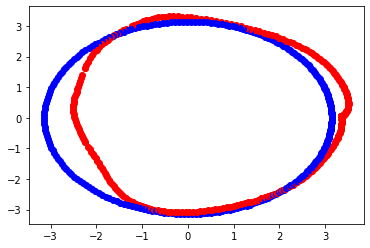

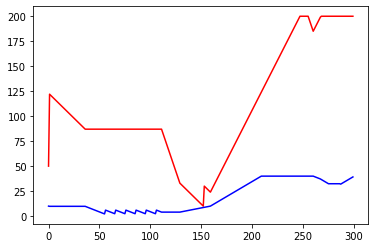

Episode : 28------Total Loss : nan------Epsilon : 0.025422772409999975


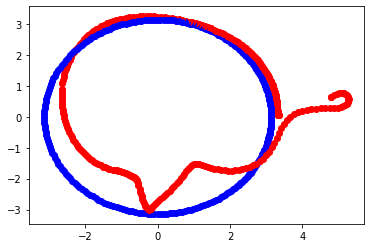

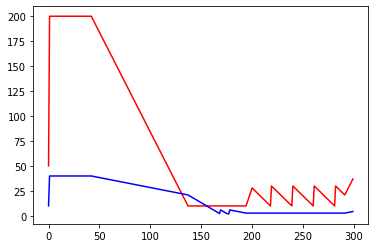

Episode : 29------Total Loss : nan------Epsilon : 0.025422772409999975


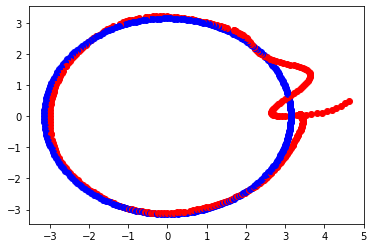

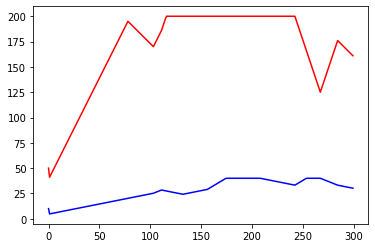

Episode : 30------Total Loss : nan------Epsilon : 0.025422772409999975


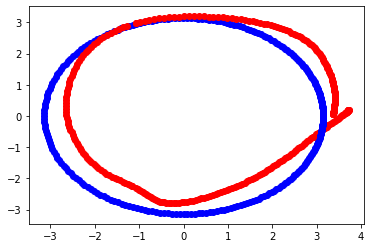

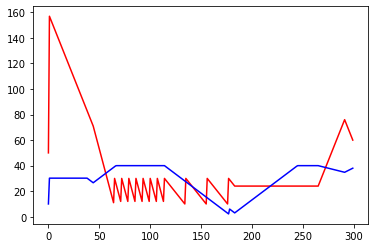

Episode : 31------Total Loss : nan------Epsilon : 0.01779594068699998


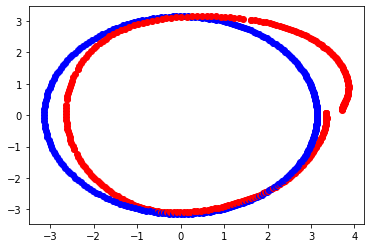

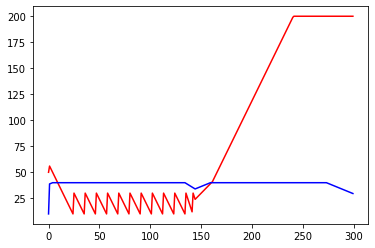

Episode : 32------Total Loss : nan------Epsilon : 0.01779594068699998


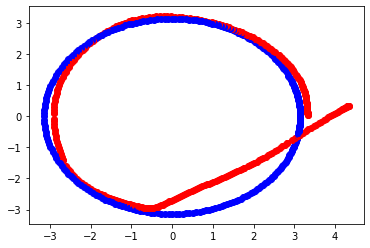

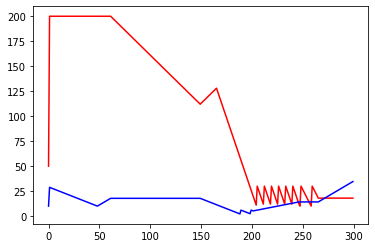

Episode : 33------Total Loss : nan------Epsilon : 0.01779594068699998


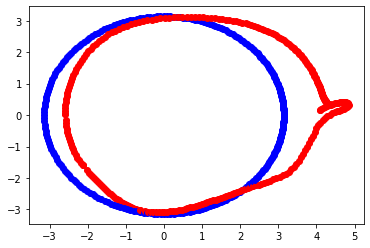

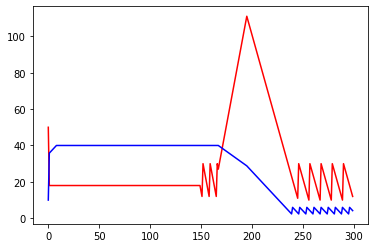

Episode : 34------Total Loss : nan------Epsilon : 0.012457158480899986


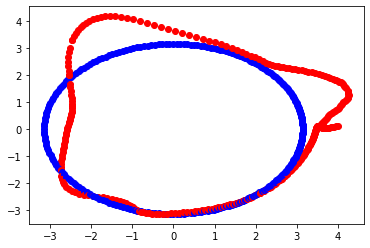

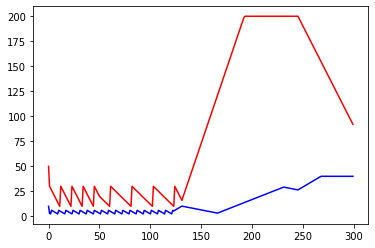

Episode : 35------Total Loss : nan------Epsilon : 0.012457158480899986


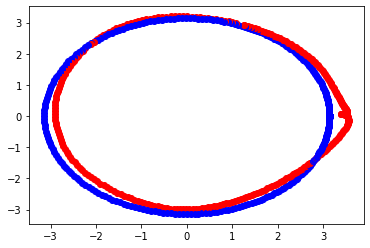

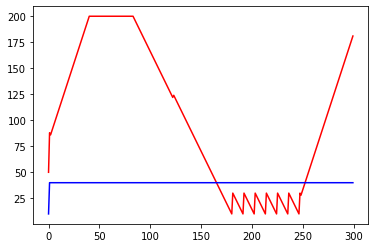

Episode : 36------Total Loss : nan------Epsilon : 0.012457158480899986


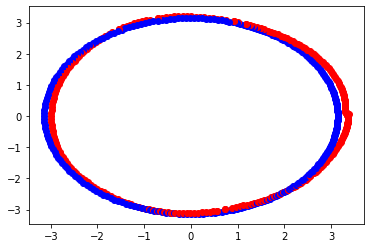

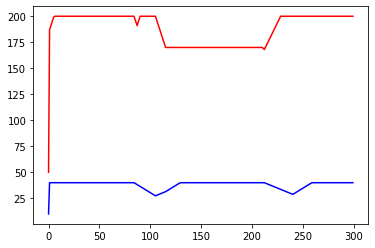

Episode : 37------Total Loss : nan------Epsilon : 0.008720010936629989


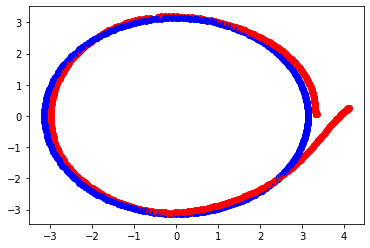

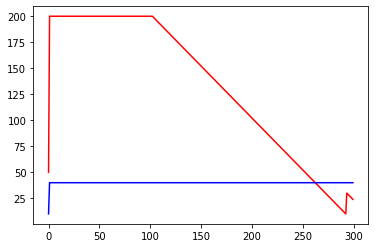

Episode : 38------Total Loss : nan------Epsilon : 0.008720010936629989


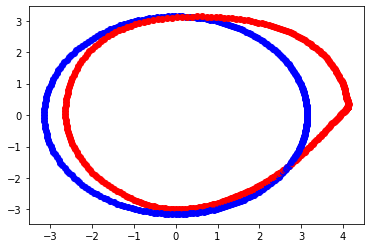

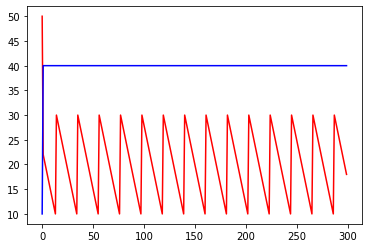

Episode : 39------Total Loss : nan------Epsilon : 0.008720010936629989


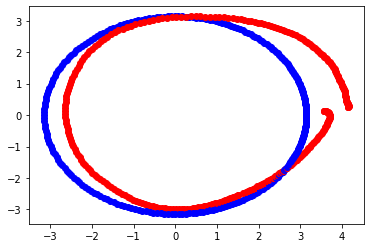

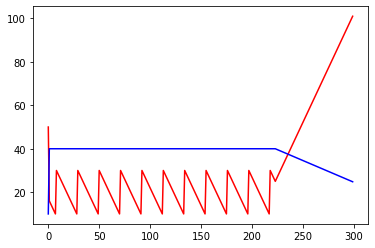

Episode : 40------Total Loss : nan------Epsilon : 0.006104007655640992


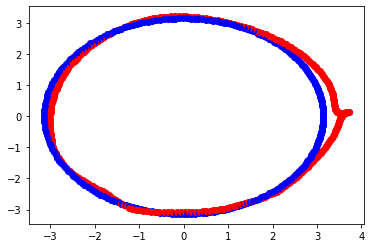

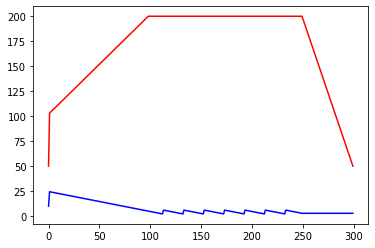

Episode : 41------Total Loss : nan------Epsilon : 0.006104007655640992


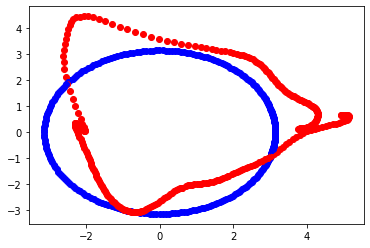

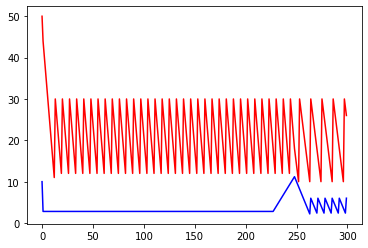

Episode : 42------Total Loss : nan------Epsilon : 0.006104007655640992


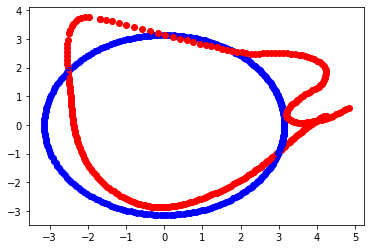

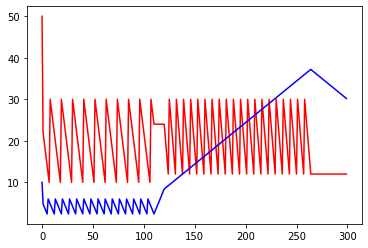

Episode : 43------Total Loss : nan------Epsilon : 0.004272805358948694


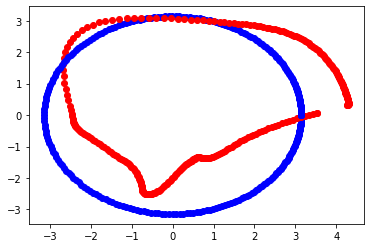

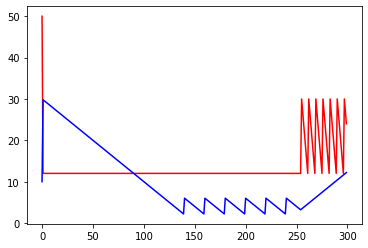

Episode : 44------Total Loss : nan------Epsilon : 0.004272805358948694


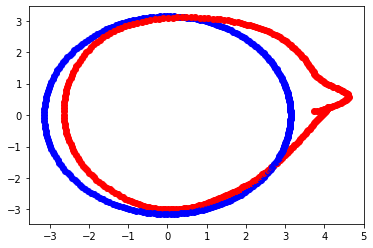

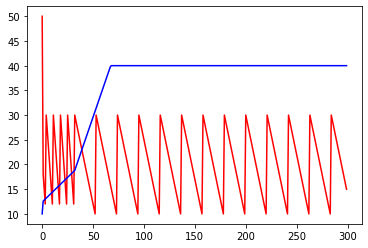

Episode : 45------Total Loss : nan------Epsilon : 0.004272805358948694


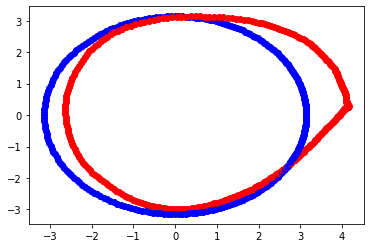

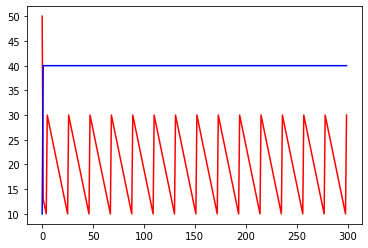

Episode : 46------Total Loss : nan------Epsilon : 0.0029909637512640854


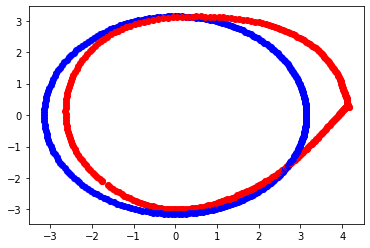

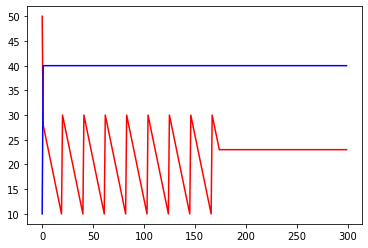

Episode : 47------Total Loss : nan------Epsilon : 0.0029909637512640854


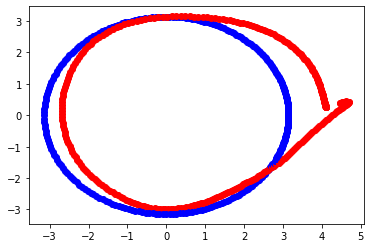

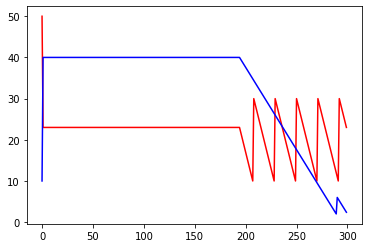

Episode : 48------Total Loss : nan------Epsilon : 0.0029909637512640854


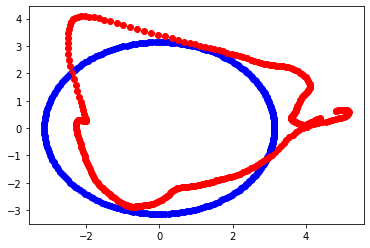

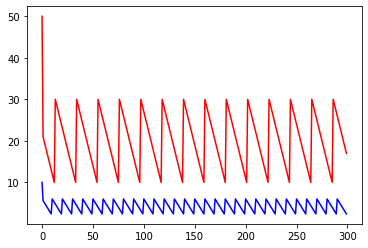

Episode : 49------Total Loss : nan------Epsilon : 0.00209367462588486


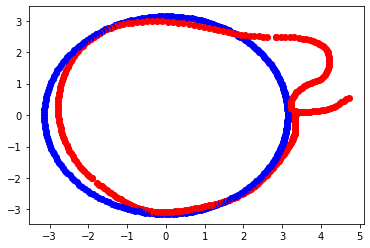

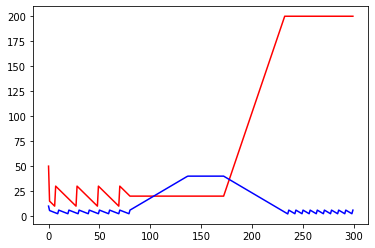

Episode : 50------Total Loss : nan------Epsilon : 0.00209367462588486


In [21]:
for episode in range(runs):

    Kp = 50
    Kd = 10
    q = q_d(0)
    q_dot = q_d_dot(0)
    err = 0
    Kp_story = []
    Kd_story = []
    tempo = []

    for t_step in enumerate(time[0:len(time):horizon]) :
        t = t_step[1]
        q_ddot_horizon = future_trajectory(t)
        policy_selection = np.random.rand()

        Kp,Kd = gainsSaturation(Kp, Kd)

        if policy_selection <= epsilon :
            a_p_idx = np.random.randint(0,7)
            a_v_idx = np.random.randint(0,7)
            gains = np.asarray([Kp,Kd])
            actions = np.asarray([actions_position[a_p_idx],actions_velocity[a_v_idx]])
            state_action = np.concatenate((q,q_dot,gains,actions,q_ddot_horizon))
            state_action = state_action.reshape((1,len(state_action)))

        else :   
            Q_s_a = float(-1000000000)
            for p in range(len(actions_position)):
                for v in range(len(actions_velocity)):
                    ap = actions_position[p]
                    av = actions_velocity[v]
                    gains = np.asarray([Kp,Kd])
                    actions = np.asarray([ap,av])
                    state_t = np.concatenate((q,q_dot,gains,actions,q_ddot_horizon))
                    state_t = state_t.reshape((1,len(state_t)))
                    value = sess.run(q_nn,{agent_state:state_t})
                    
                    if value > Q_s_a :
                        Q_s_a = value
                        state_action = state_t
        total_reward,state_t_1 = run(state_action,t)
        total_reward = total_reward.reshape((1,1))
        loss_ = sess.run(loss,{agent_state:state_action,Q : total_reward})
        sess.run(train,{agent_state:state_action,Q : total_reward})
        err += loss_

        Kp_story.append(Kp)
        Kd_story.append(Kd)

        Kp = state_t_1[0][2 * robot_dim]
        Kd = state_t_1[0][2 * robot_dim + 1]

        plt.scatter(q_d(t)[0],q_d(t)[1],color='blue')
        plt.scatter(q[0],q[1],color='red')
        
        q = state_t_1[0][0:robot_dim]
        q_dot = state_t_1[0][robot_dim:2*robot_dim]

        tempo.append(t_step[0])
        
    if episode % 3 == 0 :
        epsilon *= 0.7

    err += np.linalg.norm(q_d(T)-q) + np.linalg.norm(q_d_dot(T)-q_dot)
    plt.scatter(q_d(T)[0],q_d(T)[1],color='blue')
    plt.scatter(q[0],q[1],color='red')
    plt.show()
    plt.plot(tempo,Kp_story,color='red')
    plt.plot(tempo,Kd_story,color='blue')
    plt.show()
    print("Episode : " + str(episode +1) + "------Total Loss : " + str(err) + "------Epsilon : " + str(epsilon))